
### OBJECTIVE

Detect patients sex chromosomes from single cell metaphase chromosomes.

### BACKGROUND

### DATA

**Source:** https://www.cellimagelibrary.org/pages/auto_chromosome_detector

Total metaphase images: <number>

Train: 
- male:
- female:
- monosomy X:

Validation: 
- normal male:
- normal female:
- monosomy X:

Test: 
- normal male:
- normal female:
- monosomy X:

The input data are pictures of human single cell G-banded metaphase chromosomes in JPG format. All images are named using the scheme image_id_sexchromosomes.jpg. Variable "image_id" is a 6-digit unique identifier according to original dataset. Variable "sexchromosomes" is sex chromosomes labeled by the author (Kadi Jairus) according to International System for Human Cytogenetic Nomenclature (XX, XY or X).

### METHOD

- TensorFlow is used to develop and train a Convolutional Neural Network (CNN) architecture aimed at classifying images.
- Different CNN architectures were tested to identify the most effective structure for our classification task.
- Data augmentation techniques were applied including random rotations, flips, and brightness adjustments are applied to increase the robustness of the model and improve generalization.
- A systematic search was conducted for the optimal set of hyperparameters, including learning rate, batch size, and number of epochs.
- Various optimizers were tested such as Adam, SGD, and RMSprop to find the best algorithm for minimizing the loss function.
- A validation strategy was implemented to monitor the model's performance on unseen data during training.

In [14]:
"""Imports modules and creates directory for files."""


import datetime
import os
import shutil
import pathlib
import numpy as np
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pytz

tallinn_tz = pytz.timezone('Europe/Tallinn')
TODAY = datetime.now(tallinn_tz).strftime("%Y-%m-%d_%H-%M")

def create_report_dir(selected_model, batch_size, epochs):
    # Makes directory for current training
    report_dir = f'{TODAY}_{selected_model}_model_training_{batch_size}_batch_{epochs}_epochs'
    
    try:
        os.makedirs(report_dir, exist_ok=True)
        print(f"Directory '{report_dir}' created successfully.")
    except PermissionError:
        print(f"Permission denied: Could not create directory '{report_dir}'.")

    return report_dir


In [15]:
"""Sets up the environment and imports necessary libraries for TensorFlow and Keras."""


# Suppress tensorflow info messages
%env TF_CPP_MIN_LOG_LEVEL=2
%env TF_NUM_INTEROP_THREADS=8

# Set segmentation_models framework to the correct keras
%env SM_FRAMEWORK=tf.keras

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use mixed_float16, which is a good speedup on HPC cluster GPUs
tf.keras.config.set_dtype_policy("mixed_float16")

try: 
    tf_version = tf.__version__
    keras_version = tf.keras.__version__
    print(f"Setup succesful!\nTensorflow version {tf_version}. \nKeras version: {keras_version}")
except Exception as e:
    print(f"Setup failed :( {e}")

env: TF_CPP_MIN_LOG_LEVEL=2
env: TF_NUM_INTEROP_THREADS=8
env: SM_FRAMEWORK=tf.keras
Setup succesful!
Tensorflow version 2.16.1. 
Keras version: 3.7.0


Note: I'm sticking to tensorflow==2.16.1 because newer versions are basically broken on our system

Temp Fix from: https://github.com/tensorflow/tensorflow/issues/62075#issuecomment-2387257399

In [16]:
"""Optional code block. Checks the number of GPUs."""


num_gpus = len(tf.config.list_physical_devices('GPU'))
if num_gpus == 0:
    raise SystemError('No GPU devices found')
else:
    print(f"{num_gpus} gpu(s) found")

1 gpu(s) found


In [17]:
"""Specifies the location of data. Creates directories for models and logs."""


# Uncomment below to download data into localstorage
#!bash download_data.sh "/localstorage/$USER/isic_data"
def create_dirs_for_model_and_logs(data_dir, report_dir):
    data_dir = pathlib.Path(data_dir)
    if not data_dir.exists():
        raise ValueError("The specified data directory does not exist.")
        
    train_dir = data_dir / "train"
    val_dir = data_dir / "val"
    test_dir = data_dir / "test"
    
    logs_path = f"{report_dir}/logs"
    models_path = "models"
    
    try:
        os.makedirs(logs_path, exist_ok=True)
        os.makedirs(models_path, exist_ok=True) 
        print(f"Directories for logs and models created successfully in {report_dir}.")
    except PermissionError as e:
        print(f"Permission denied: Could not create needed directories. {e}")

    return (train_dir, val_dir, test_dir)

In [18]:
"""Defines how picture data will be generated."""


from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators():
    # Define a training image data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Rescale pixel values: 0 to 1, not to 255.
        rotation_range=20,  # Random rotations, 20 degrees.
        width_shift_range=None,  # Random horizontal shifts
        height_shift_range=0.2,  # Random vertical shifts
        shear_range=0.2,  # Shearing (darkness)
        zoom_range=0.2,  # Zooming
        horizontal_flip=True,  # Horizontal flipping
        fill_mode='nearest'
    )
    
    # Defines a testing/validation image data generator with NO augmentation, only rescaling
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    return(train_datagen, val_datagen, test_datagen)

In [19]:
"""Option 1. Defines the CNN model."""


def create_cnn(num_classes):
    """
    Define model architecture.
    :param int: height, width, channels
    :param int: number of classes
    :return: model
    """
    model = Sequential()
    # Convolutional layer with ReLU activation. 32 (pow of two) filters. 3x3 filter size. Input shape is picture resolution.
    
    # Define the input shape with an Input layer
    model.add(Input(shape=input_shape))  # Define the input shape here
    
    model.add(Conv2D(32, (4, 4), activation='relu', input_shape=input_shape))
    # Max pooling layer
    model.add(MaxPooling2D((2, 2)))
    # Additional convolutional layer
    model.add(Conv2D(64, (4, 4), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Additional convolutional layer
    model.add(Conv2D(64, (4, 4), activation='relu'))
   
    # Flatten the output and add dense layers
    model.add(Flatten())
    # 64 is number of neurons.
    model.add(Dense(64, activation='relu'))
    # Output layer with softmax activation
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [20]:
"""Option 2. Defines the pre-trained Xception model."""


from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D


def create_xception(input_shape, num_classes, dropout_rate):
    """
    Define model architecture.
    
    :param int: height, width, channels
    :param int: number of classes
    :return: model
    """
    # Load Xception base without top layers
    base_model = Xception(
        include_top=False,
        weights="imagenet",
        input_shape=(input_shape)
    )
    
    # Only train last layers
    base_model.trainable = False

    
    # Add custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    """
    # Add custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),  # Increased size for more capacity
        Dropout(dropout_rate),          # Dropout layer to reduce overfitting
        Dense(64, activation='relu'),   # Another Dense layer for more complexity
        Dropout(dropout_rate),          # Dropout layer
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    """
    
    return model


In [21]:
"""Option 3. Defines Alexnet model with dropout."""


def create_alexnet(input_shape, num_classes):
    modelAlexNet = Sequential([
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return modelAlexNet

In [22]:
"""Optional code block. Remove checkpoints if 4 classes instead of 3."""


def remove_ipynb_checkpoints(directory):
    for root, dirs, files in os.walk(directory):
        if '.ipynb_checkpoints' in dirs:
            checkpoint_path = os.path.join(root, '.ipynb_checkpoints')
            shutil.rmtree(checkpoint_path)
            print(f"Removed {checkpoint_path}")

    # Apply to train, val, and test directories
    remove_ipynb_checkpoints(train_dir)
    remove_ipynb_checkpoints(val_dir)
    remove_ipynb_checkpoints(test_dir)

In [23]:
"""Generates training, validation and testing data."""


def get_data_generators(img_size, batch_size):
    # Changes parameters after each batch
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    # Loads images from the testing directory
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  # Matching the class_mode of the training data
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Ensure the generator does not shuffle the images
    )
    
    print("Class indices for training data:", train_generator.class_indices)
    print("Class indices for validation data:", val_generator.class_indices)
    print("Class indices for testing data:", test_generator.class_indices)

    return (train_generator, val_generator, test_generator)

In [24]:
"""Option 1. Specifies variables, compiles model with single hyperparameter set and creates summary."""


def compile_model(report_dir, selected_model, input_shape, num_classes, dropout_rate, optimizer_name, learning_rate):
    
    if selected_model == "xception":
        model = create_xception(input_shape, num_classes, dropout_rate)
    elif selected_model == "alexnet":
        model = create_alexnet(input_shape, num_classes)
    else:
        model = create_cnn(num_classes)

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unexpected optimizer name: {optimizer_name}")
       
    # Compiles the model 'adam' or 'sgd' optimizer
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    
    # Saves model summary in table format
    summary_file = f"{report_dir}/{TODAY}_Model_{selected_model}_architecture_summary_optimizer_{optimizer}.txt"
    with open(summary_file, 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    # Shows the model
    model.summary()
    
    # Shows model as a graph
    tf.keras.utils.plot_model(
        model,
        to_file=f"{report_dir}/{TODAY}_Model_{selected_model}_graph_optimizer_{optimizer_name}.png",
        show_shapes=True,
        show_dtype=True,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=True,
        dpi=60,
    )
    
    return model

In [25]:
"""Option 1. Trains model with single hyperparameter set and writes to file."""


from tensorflow.keras.callbacks import Callback


def train_model(report_dir, model, train_generator, val_generator, epochs, batch_size, optimizer):
    # Fit the model to the training data
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Ensures the model sees the x_train samples per epoch
                                                                                # allows you to control how much data the model
                                                                                # should consume before declaring one epoch complete and moving on to the next epoch.
        epochs=epochs,  # Number of epochs to train for
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )
    
    keys = model.history.history.keys()
    print(f"Model history keys are: \n{keys}")
    
    # Generate plots
    f,ax=plt.subplots(2,2, figsize=(12,6))
    try:
      #1st subplot: training loss and validation loss
      ax[0, 0].plot(model.history.history['loss'],color='b',label='train_loss')
      ax[0, 0].plot(model.history.history['val_loss'],color='r',label='val_loss')
      ax[0, 0].legend(loc="upper right")
    except Exception as e:
        print(f'Creating plot 0,0 failed: {e}')
    
    try:
      #2nd subplot: training accuracy and validation accuracy
      ax[0, 1].plot(model.history.history['accuracy'],color='b',label='train_accuracy')
      ax[0, 1].plot(model.history.history['val_accuracy'],color='r',label='val_accuracy')
      ax[0, 1].legend(loc="lower right")
    except Exception as e:
        print(f'Creating plot 0,1 failed: {e}')
    
    try:
      #3rd subplot: training precision and validation precision
      ax[1, 0].plot(model.history.history['precision'],color='b',label='train_precision')
      ax[1, 0].plot(model.history.history['val_precision'],color='r',label='val_precision')
      ax[1, 0].legend(loc="lower right")
    except Exception as e:
        print(f'Creating plot 1,0 failed: {e}')
    
    try:
      #4th subplot: training recall and validation recall
      ax[1, 1].plot(model.history.history['recall'],color='b',label='train_recall')
      ax[1, 1].plot(model.history.history['val_recall'],color='r',label='val_recall')
      ax[1, 1].legend(loc="lower right")
    except Exception as e:
        print(f'Creating plot 1,1 failed: {e}')
    
    # Save plots
    filename = f"{report_dir}/{TODAY}_CNN_training_plot_{epochs}_epochs_{batch_size}_batches_optimizer_{optimizer}.png"
    try:
        plt.savefig(filename)
        print('Saved figure')
    except Exception as e:
        print(f'Saving figure to first location failed: {e}')
        try:
          plt.savefig('training_image_bug')
          print('Saved figure to home directory')
        except Exception as e:
          print(f'Saving figure failed: {e}')

    return model


Directory '2024-12-29_10-41_xception_model_training_8_batch_200_epochs' created successfully.
Directories for logs and models created successfully in 2024-12-29_10-41_xception_model_training_8_batch_200_epochs.
Found 997 images belonging to 3 classes.
Found 288 images belonging to 3 classes.
Found 288 images belonging to 3 classes.
Class indices for training data: {'female': 0, 'male': 1, 'monosomy': 2}
Class indices for validation data: {'female': 0, 'male': 1, 'monosomy': 2}
Class indices for testing data: {'female': 0, 'male': 1, 'monosomy': 2}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,927,147 (79.83 MB)

 Trainable params: 65,667 (256.51 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Training model xception:
 epochs: 200 
 batch_size: 8 
 optimizer: adam 
 learning rate: 0.0001 
 dropout_rate: 0.5


/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 83s 633ms/step - accuracy: 0.3866 - loss: 1.0872 - precision_1: 0.3169 - recall_1: 0.0199 - val_accuracy: 0.3160 - val_loss: 1.1841 - val_precision_1: 0.3390 - val_recall_1: 0.0694
Epoch 2/200
  1/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6250 - loss: 1.0023 - precision_1: 0.5000 - recall_1: 0.1250

/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6250 - loss: 1.0023 - precision_1: 0.5000 - recall_1: 0.1250 - val_accuracy: 0.3160 - val_loss: 1.1840 - val_precision_1: 0.3103 - val_recall_1: 0.0625
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.4364 - loss: 1.0444 - precision_1: 0.5984 - recall_1: 0.0423 - val_accuracy: 0.3264 - val_loss: 1.1689 - val_precision_1: 0.3585 - val_recall_1: 0.0660
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5000 - loss: 1.1295 - precision_1: 1.0000 - recall_1: 0.1250 - val_accuracy: 0.3299 - val_loss: 1.1710 - val_precision_1: 0.3387 - val_recall_1: 0.0729
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.4236 - loss: 1.0437 - precision_1: 0.5347 - recall_1: 0.0681 - val_accuracy: 0.3507 - val_loss: 1.1298 - val_precision_1: 0.3478 - val_recall_1: 0.0278
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5000 - loss: 0.9438 - precision_1: 0.0000e+00 - recall_1: 0.00

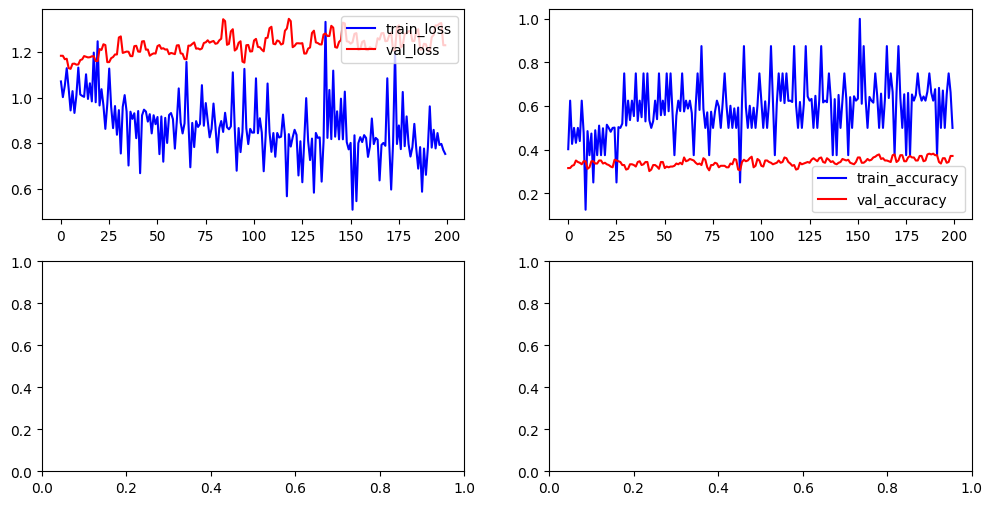

In [26]:
"""Main."""


"""Adjusts the parameters."""
IMG_SIZE = (300, 300)
INPUT_SHAPE = (300, 300, 3)
SELECTED_MODEL = "xception"
# Uses 'adam' or 'sgd' optimizer
OPTIMIZER = "adam"
BATCH_SIZE = 8
EPOCHS = 200
DROPOUT_RATE = 0.5
LEARNING_RATE = 1e-4
NUM_CLASSES = 3

"""Creates directories."""
REPORT_DIR = create_report_dir(SELECTED_MODEL, BATCH_SIZE, EPOCHS)

dirs = create_dirs_for_model_and_logs("data", REPORT_DIR)
train_dir = dirs[0]
val_dir = dirs[1]
test_dir = dirs[2]

"""Generates data."""
data_gens = create_data_generators()
train_datagen = data_gens[0]
val_datagen = data_gens[1]
test_datagen = data_gens[2]

generators = get_data_generators(IMG_SIZE, BATCH_SIZE)
train_generator = generators[0]
val_generator = generators[1]
test_generator = generators[2]

"""Compiles model."""
model = compile_model(REPORT_DIR, SELECTED_MODEL, INPUT_SHAPE, NUM_CLASSES, DROPOUT_RATE, OPTIMIZER, LEARNING_RATE)

"""Writes training details to file."""
print(f"Training model {SELECTED_MODEL}:\n epochs: {EPOCHS} \n batch_size: {BATCH_SIZE} \n optimizer: {OPTIMIZER} \n learning rate: {LEARNING_RATE} \n dropout_rate: {DROPOUT_RATE}") 
info_file = os.path.join(REPORT_DIR, f"{TODAY}_training_info_{EPOCHS}_{BATCH_SIZE}_{OPTIMIZER}.txt")
with open(info_file, "w") as f:
    f.write(f"Training model {SELECTED_MODEL}:\n")
    f.write(f"epochs: {EPOCHS}\n")
    f.write(f"batch_size: {BATCH_SIZE}\n")
    f.write(f"optimizer: {OPTIMIZER}\n")
    f.write(f"learning rate: {LEARNING_RATE}\n")
    f.write(f"dropout_rate: {DROPOUT_RATE}\n")

"""Trains model."""
trained_model = train_model(REPORT_DIR, model, train_generator, val_generator, EPOCHS, BATCH_SIZE, OPTIMIZER)

"""Saves model."""
save_path = f"models/{TODAY}_Cyto_cnn_{SELECTED_MODEL}_model_{EPOCHS}_epochs_{BATCH_SIZE}_batches_optimizer_{OPTIMIZER}_lr_{LEARNING_RATE}.keras"
trained_model.save(save_path)

In [41]:
"""Option 2. Define multiple sets of hyperparameters."""

from tensorboard.plugins.hparams import api as hp

# Define hyperparameters for tuning
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-1, 1e-4]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.3, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
METRIC_ACCURACY = 'accuracy'

In [42]:
"""Option 2. Trains model with multiple sets of hyperparameters and writes to file."""

import os
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.metrics import Precision, Recall


root_logdir = os.path.join(os.curdir, "logs")
run_name = ''  # Placeholder for dynamic run names


def get_run_logdir():
    run_id = time.strftime("run_" + run_name + "_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


# TensorBoard summary for hyperparameter tuning
with tf.summary.create_file_writer('logs/{today}_hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_LEARNING_RATE, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )


def create_model(input_shape, num_classes, dropout_rate, optimizer_name, learning_rate):
    """
    Create model architecture and compile based on selected hyperparameters.
    """
    if SELECTED_MODEL == "xception":
        model = create_xception(input_shape, num_classes, dropout_rate)
    elif SELECTED_MODEL == "alexnet":
        model = create_alexnet(input_shape, num_classes)
    else:
        model = create_cnn(num_classes)

    # Compile the model with dynamic optimizer and learning rate
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unexpected optimizer name: {optimizer_name}")
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    return model


def train_test_model(hparams):
    """
    Train and evaluate the model with the current hyperparameter configuration.
    """
    dropout_rate = hparams[HP_DROPOUT]
    optimizer_name = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]

    model = create_model(INPUT_SHAPE, num_classes, dropout_rate, optimizer_name, learning_rate)

    # Save model summary
    summary_file = f"{report_dir}/{today}_Model_{SELECTED_MODEL}_architecture_summary_optimizer_{optimizer_name}_learning_rate_{learning_rate}.txt"
    with open(summary_file, 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    model.summary()

    # Show model as a graph
    tf.keras.utils.plot_model(
        model,
        to_file=f"{report_dir}/{today}_Model_{SELECTED_MODEL}_graph_optimizer_{optimizer_name}.png",
        show_shapes=True,
        show_dtype=True,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=True,
        dpi=60,
    )

    # Fit the model
    model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=val_generator.samples // val_generator.batch_size,
        callbacks=[
            tf.keras.callbacks.TensorBoard(get_run_logdir()),  # Log metrics to TensorBoard
            hp.KerasCallback(get_run_logdir(), hparams)  # Log hyperparameters to TensorBoard
        ]
    )

    # Evaluate the model
    _, accuracy = model.evaluate(test_generator)
    return accuracy


def run(run_dir, hparams):
    """
    Run training and log metrics and hyperparameters.
    """
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # Log hyperparameters for this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


# Start running the experiments with different hyperparameters
session_num = 0

# Iterate over the hyperparameters and run experiments
for dropout_rate in HP_DROPOUT.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:
            hparams = {
                HP_LEARNING_RATE: learning_rate,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

# Saves model
save_path = f"models/{today}_Cyto_cnn_{SELECTED_MODEL}_model_{EPOCHS}_epochs_{BATCH_SIZE}_batches_optimizer_{OPTIMIZER}_dropout_{dropout_rate}_learning_rate_{learning_rate}.keras"
model.save(save_path)

--- Starting trial: run-0
{'learning_rate': 0.0001, 'dropout': 0.3, 'optimizer': 'adam'}


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,132,203 (80.61 MB)

 Trainable params: 270,723 (1.03 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4659 - loss: 1.0489 - precision_2: 0.4909 - recall_2: 0.2017 - val_accuracy: 0.3750 - val_loss: 1.0888 - val_precision_2: 0.4118 - val_recall_2: 0.0547
Epoch 2/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4375 - loss: 1.1131 - precision_2: 0.3333 - recall_2: 0.1250

/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4375 - loss: 1.1131 - precision_2: 0.3333 - recall_2: 0.1250 - val_accuracy: 0.3984 - val_loss: 1.0883 - val_precision_2: 0.4286 - val_recall_2: 0.0234
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 937ms/step - accuracy: 0.4540 - loss: 1.0524 - precision_2: 0.4005 - recall_2: 0.1044 - val_accuracy: 0.3594 - val_loss: 1.0899 - val_precision_2: 0.6000 - val_recall_2: 0.0234
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4219 - loss: 1.0535 - precision_2: 0.2727 - recall_2: 0.0469 - val_accuracy: 0.3594 - val_loss: 1.0902 - val_precision_2: 0.6000 - val_recall_2: 0.0234
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 940ms/step - accuracy: 0.4664 - loss: 1.0331 - precision_2: 0.5430 - recall_2: 0.1023 - val_accuracy: 0.3438 - val_loss: 1.0896 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3281 - loss: 1.0798 - precision_2: 0.2000 - recall_2: 0.0625 -

ValueError: too many values to unpack (expected 2)

In [39]:
"""Test model."""


import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy, Precision, Recall


def test_model(model_path):
    try: 
        model = tf.keras.models.load_model(model_path, compile=False)
        print(f"Loading model successful! Path: {model_path}")
    except Exception as e:
        print(f"Loading model failed. {e}")

    # Predictions and true labels
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    
    # Keras metrics
    accuracy_metric = Accuracy()
    accuracy_metric.update_state(true_labels, predicted_classes)
    accuracy = accuracy_metric.result().numpy()
    
    # Generate a confusion matrix manually
    conf_matrix = np.zeros((len(class_labels), len(class_labels)), dtype=int)
    for true, pred in zip(true_labels, predicted_classes):
        conf_matrix[true, pred] += 1
    
    # Calculate precision and recall for each class
    precision_metric = Precision()
    recall_metric = Recall()
    
    precision_metric.update_state(to_categorical(true_labels, num_classes=len(class_labels)), predictions)
    recall_metric.update_state(to_categorical(true_labels, num_classes=len(class_labels)), predictions)
    
    precision = precision_metric.result().numpy()
    recall = recall_metric.result().numpy()
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Save the report
    filename = f"{report_dir}/{today}_classification_report_model_{SELECTED_MODEL}_batch_{BATCH_SIZE}_optimizer_{OPTIMIZER}.txt"
    try:
        os.makedirs(report_dir, exist_ok=True)
        with open(filename, 'w') as f:
            f.write("Classification Report\n")
            f.write(f"Accuracy: {accuracy:.4f}\n")
            f.write(f"Precision: {precision:.4f}\n")
            f.write(f"Recall: {recall:.4f}\n")
            f.write("\nConfusion Matrix:\n")
            for row in conf_matrix:
                f.write(' '.join(map(str, row)) + '\n')
    except Exception as e:
        print(f"Error saving report: {e}")
    
    # Plot incorrect predictions
    incorrect_indices = np.where(predicted_classes != true_labels)[0]
    
    # Reset generator
    test_generator.reset()
    
    # Visualize incorrect predictions
    num_samples_to_plot = 10
    plotted_count = 0
    
    for i in range(len(test_generator)):
        images, labels = next(test_generator)
    
        # Check batch size
        if len(images) == 0:
            continue
    
        batch_start_index = i * test_generator.batch_size
        batch_end_index = batch_start_index + len(labels)
    
        batch_incorrect_indices = [idx for idx in incorrect_indices
                                   if batch_start_index <= idx < batch_end_index]
        batch_relative_indices = [idx - batch_start_index for idx in batch_incorrect_indices]
    
        for idx in batch_relative_indices:
            if plotted_count >= num_samples_to_plot:
                break
    
            plt.figure(figsize=(4, 4))
            plt.imshow((images[idx] * 255).astype("uint8"))
            true_class = class_labels[true_labels[batch_start_index + idx]]
            predicted_class = class_labels[predicted_classes[batch_start_index + idx]]
    
            plt.title(f"True: {true_class}, Predicted: {predicted_class}")
            plt.axis('off')
    
            plot_filename = f"{report_dir}/Wrong_prediction_{plotted_count + 1}_{true_class}_predicted_{predicted_class}.png"
            plt.savefig(plot_filename, format='png')
            plt.show()
    
            plotted_count += 1
    
        if plotted_count >= num_samples_to_plot:
            break

        print("Testing model succesful!")


In [ ]:
"""Test model from path"""

test_model(save_path)


--- Starting trial: run-0
{'learning_rate': 0.0001, 'dropout': 0.3, 'optimizer': 'adam'}


/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 710432)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    90,935,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,936,707 (346.90 MB)

 Trainable params: 90,936,707 (346.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.3818 - loss: 6.4244 - precision_2: 0.3730 - recall_2: 0.3341 - val_accuracy: 0.3333 - val_loss: 10.4761 - val_precision_2: 0.3333 - val_recall_2: 0.3333
Epoch 2/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3750 - loss: 8.2140 - precision_2: 0.3750 - recall_2: 0.3750 - val_accuracy: 0.3333 - val_loss: 10.7454 - val_precision_2: 0.3333 - val_recall_2: 0.3333
Epoch 3/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 917ms/step - accuracy: 0.3573 - loss: 9.0498 - precision_2: 0.3573 - recall_2: 0.3573 - val_accuracy: 0.3333 - val_loss: 9.1008 - val_precision_2: 0.3333 - val_recall_2: 0.3333
Epoch 4/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 8.2826 - precision_2: 0.3438 - recall_2: 0.3438 - val_accuracy: 0.3333 - val_loss: 9.3558 - val_precision_2: 0.3333 - val_recall_2: 0.3333
Epoch 5/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 573ms/step - accuracy: 0.3953 - loss: 7.5210 - precision_2: 0.3953 - recall_2: 0.3953 -

NameError: name 'model' is not defined

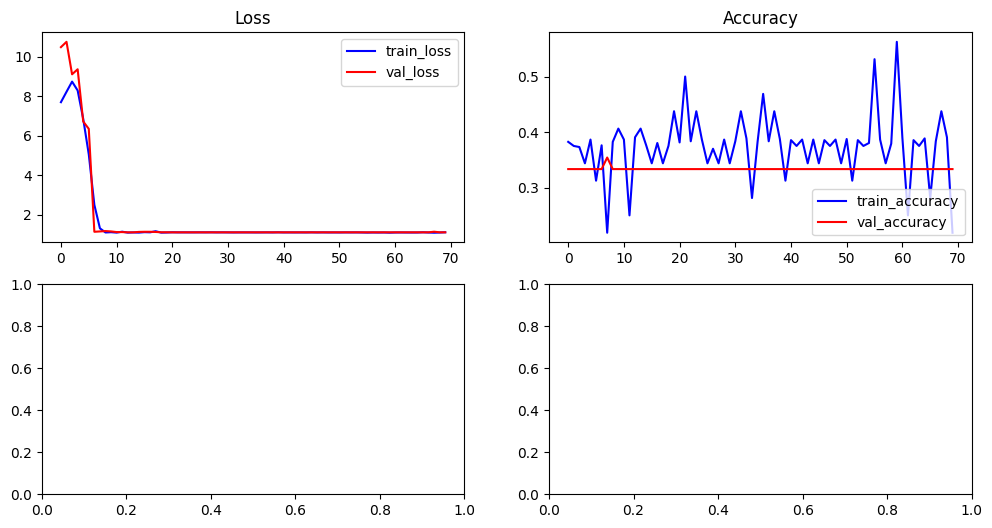

In [40]:
"""Option 2. Train multiple"""


from tensorboard.plugins.hparams import api as hp

# Hyperparameters for tuning
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-1, 1e-4]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.3, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
METRIC_ACCURACY = 'accuracy'
NUM_CLASSES = 3
BATCH_SIZE = 16

# Function to create the model with hyperparameters
def create_model(input_shape, NUM_CLASSES, dropout_rate, optimizer_name, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    # Choose optimizer
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    
    return model

# Training and testing function
def train_test_model(hparams):
    dropout_rate = hparams[HP_DROPOUT]
    optimizer_name = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]

    # Create model with the given hyperparameters
    model = create_model(INPUT_SHAPE, NUM_CLASSES, dropout_rate, optimizer_name, learning_rate)

    # Model summary
    model_summary_file = f"{report_dir}/{today}_Model_{SELECTED_MODEL}_architecture_summary_optimizer_{optimizer_name}_learning_rate_{learning_rate}.txt"
    with open(model_summary_file, 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    model.summary()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=val_generator.samples // val_generator.batch_size,
        callbacks=[tf.keras.callbacks.TensorBoard(f"{report_dir}/{optimizer_name}_{learning_rate}_{dropout_rate}")]
    )

    # Generate plots after training
    try:
        f, ax = plt.subplots(2, 2, figsize=(12, 6))

        # 1st subplot: Training loss vs validation loss
        ax[0, 0].plot(history.history['loss'], color='b', label='train_loss')
        ax[0, 0].plot(history.history['val_loss'], color='r', label='val_loss')
        ax[0, 0].legend(loc="upper right")
        ax[0, 0].set_title("Loss")

        # 2nd subplot: Training accuracy vs validation accuracy
        ax[0, 1].plot(history.history['accuracy'], color='b', label='train_accuracy')
        ax[0, 1].plot(history.history['val_accuracy'], color='r', label='val_accuracy')
        ax[0, 1].legend(loc="lower right")
        ax[0, 1].set_title("Accuracy")

        # 3rd subplot: Training precision vs validation precision
        ax[1, 0].plot(history.history['precision'], color='b', label='train_precision')
        ax[1, 0].plot(history.history['val_precision'], color='r', label='val_precision')
        ax[1, 0].legend(loc="lower right")
        ax[1, 0].set_title("Precision")

        # 4th subplot: Training recall vs validation recall
        ax[1, 1].plot(history.history['recall'], color='b', label='train_recall')
        ax[1, 1].plot(history.history['val_recall'], color='r', label='val_recall')
        ax[1, 1].legend(loc="lower right")
        ax[1, 1].set_title("Recall")

        # Save the figure
        filename = f"{report_dir}/{today}_CNN_training_plot_{EPOCHS}_epochs_{BATCH_SIZE}_batches_optimizer_{optimizer_name}_lr_{learning_rate}_dropout_{dropout_rate}.png"
        plt.savefig(filename)
        print(f"Saved figure: {filename}")
    except Exception as e:
        print(f"Error while generating or saving the plots: {e}")

    # Evaluate the model
    _, accuracy = model.evaluate(test_generator)
    return accuracy

# Run the hyperparameter tuning experiment
def run_hyperparameter_tuning():
    session_num = 0
    for dropout_rate in HP_DROPOUT.domain.values:
        for optimizer in HP_OPTIMIZER.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values:
                hparams = {
                    HP_LEARNING_RATE: learning_rate,
                    HP_DROPOUT: dropout_rate,
                    HP_OPTIMIZER: optimizer,
                }
                run_name = f"run-{session_num}"
                print(f'--- Starting trial: {run_name}')
                print({h.name: hparams[h] for h in hparams})
                run_dir = f"{report_dir}/{run_name}"
                os.makedirs(run_dir, exist_ok=True)
                with tf.summary.create_file_writer(run_dir).as_default():
                    tf.summary.scalar(METRIC_ACCURACY, train_test_model(hparams), step=1)
                session_num += 1

# Start the hyperparameter tuning experiments
try:
    run_hyperparameter_tuning()
except Exception as e:
    print(f"Error during hyperparameter tuning: {e}")

# Save the best model after tuning
save_path = f"models/{today}_Best_Cyto_cnn_{SELECTED_MODEL}_model_{EPOCHS}_epochs_{BATCH_SIZE}_batches_best_model.keras"
model.save(save_path)
print("Best model saved successfully.")

"""
def train_test_model(hparams):
    dropout_rate = hparams[HP_DROPOUT]
    optimizer_name = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]

    # Create model
    model = create_model(INPUT_SHAPE, num_classes, dropout_rate, optimizer_name, learning_rate)

    # Save model summary
    summary_file = f"{report_dir}/{today}_Model_{SELECTED_MODEL}_architecture_summary_optimizer_{optimizer_name}_learning_rate_{learning_rate}.txt"
    with open(summary_file, 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    model.summary()

    # Show model as a graph
    tf.keras.utils.plot_model(
        model,
        to_file=f"{report_dir}/{today}_Model_{SELECTED_MODEL}_graph_optimizer_{optimizer_name}.png",
        show_shapes=True,
        show_dtype=True,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=True,
        dpi=60,
    )

    # Fit the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=val_generator.samples // val_generator.batch_size,
        callbacks=[
            tf.keras.callbacks.TensorBoard(get_run_logdir())  # Log metrics to TensorBoard
        ]
    )

    # Generate plots for training history
    try:
        f, ax = plt.subplots(2, 2, figsize=(12, 6))

        # 1st subplot: Training loss vs validation loss
        ax[0, 0].plot(history.history['loss'], color='b', label='train_loss')
        ax[0, 0].plot(history.history['val_loss'], color='r', label='val_loss')
        ax[0, 0].legend(loc="upper right")
        ax[0, 0].set_title("Loss")

        # 2nd subplot: Training accuracy vs validation accuracy
        ax[0, 1].plot(history.history['accuracy'], color='b', label='train_accuracy')
        ax[0, 1].plot(history.history['val_accuracy'], color='r', label='val_accuracy')
        ax[0, 1].legend(loc="lower right")
        ax[0, 1].set_title("Accuracy")

        # 3rd subplot: Training precision vs validation precision
        ax[1, 0].plot(history.history['precision'], color='b', label='train_precision')
        ax[1, 0].plot(history.history['val_precision'], color='r', label='val_precision')
        ax[1, 0].legend(loc="lower right")
        ax[1, 0].set_title("Precision")

        # 4th subplot: Training recall vs validation recall
        ax[1, 1].plot(history.history['recall'], color='b', label='train_recall')
        ax[1, 1].plot(history.history['val_recall'], color='r', label='val_recall')
        ax[1, 1].legend(loc="lower right")
        ax[1, 1].set_title("Recall")

        # Save the figure
        filename = f"{report_dir}/{today}_CNN_training_plot_{EPOCHS}_epochs_{BATCH_SIZE}_batches_optimizer_{optimizer_name}_lr_{learning_rate}_dropout_{dropout_rate}.png"
        plt.savefig(filename)
        print(f"Saved figure: {filename}")
    except Exception as e:
        print(f"Error while generating or saving the plots: {e}")

    # Evaluate the model on the test data
    _, accuracy = model.evaluate(test_generator)
    return accuracy

def run_hyperparameter_tuning():
    session_num = 0
    for dropout_rate in HP_DROPOUT.domain.values:
        for optimizer in HP_OPTIMIZER.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values:
                hparams = {
                    HP_LEARNING_RATE: learning_rate,
                    HP_DROPOUT: dropout_rate,
                    HP_OPTIMIZER: optimizer,
                }
                run_name = f"run-{session_num}"
                print(f'--- Starting trial: {run_name}')
                print({h.name: hparams[h] for h in hparams})
                run_dir = f"logs/hparam_tuning/{run_name}"
                os.makedirs(run_dir, exist_ok=True)
                with tf.summary.create_file_writer(run_dir).as_default():
                    tf.summary.scalar(METRIC_ACCURACY, train_test_model(hparams), step=1)
                session_num += 1

# Start hyperparameter tuning experiments
run_hyperparameter_tuning()

# After hyperparameter tuning is done, save the best model
save_path = f"models/{today}_Best_Cyto_cnn_{SELECTED_MODEL}_model_{EPOCHS}_epochs_{BATCH_SIZE}_batches_best_model.keras"
model.save(save_path)
print("Model saved successfully.")
"""
                                                                           

                                                                           
                                                                           